In [1]:
import warnings
warnings.filterwarnings('ignore')

# import gensim
from gensim.models.ldamodel import LdaModel
from gensim.models import Phrases
from gensim import corpora, models

# import spacy
from spacy.lang.id import Indonesian
nlp = Indonesian()  # use directly
stopwords = spacy.lang.id.stop_words.STOP_WORDS 
stopwords |= {"nya"}
from json import loads
from ast import literal_eval
from pickle import dump

# from gensim import corpora, models
from gensim.models.coherencemodel import CoherenceModel
#show graphs
import matplotlib.pyplot as plt

In [2]:
# #Akronim
def slang(tokenized_sentence):
    slang_word_dict = loads(open("slang_word_dict.txt", 'r').read())

    for index in range(len(tokenized_sentence)):
        for key, value in slang_word_dict.items():
            for v in value:
                if tokenized_sentence[index] == v:
                    tokenized_sentence[index] = key
                else:
                    continue
                    
    return " ".join(tokenized_sentence)

def preprocessing(text):
    text = re.sub('<[^<]+?>', '', str(text)) #remove tag\n",
    text = text.lower() #lower\n",
    text = re.sub(r'[^\w]',' ',str(text)) #remove punct\n",
    text = re.sub(r'\s+', ' ', text) #remove white space\n",
    text = [token.text for token in nlp(text)] #Token
    text = slang(text)#slang word
    text = stopword(text)
#     text = [token.lemma_ for token in nlp(text) if token.lemma_ not in stopwords] #Lemma & stopword
    
    return text

#function to compute coherence values
def compute_coherence_values(dictionary, corpus, texts, limit, start, step):
    coherence_values = []
    model_list = []
    for num_topics in range(start, limit, step):
        model = LdaModel(corpus=corpus, id2word=dictionary, num_topics=num_topics, random_state=500)
        model_list.append(model)
        coherencemodel = CoherenceModel(model=model, texts=texts, dictionary=dictionary, coherence='c_v')
        coherence_values.append(coherencemodel.get_coherence())
        
    return model_list, coherence_values

In [3]:
#Load Clean data
data = pd.read_csv('data_berita_clean.csv')

#Make list of list
mylist = []

for i,j in data.iterrows():
    tmp = literal_eval(j.content)
    mylist.append(tmp)
    
# Add bigrams and trigrams to docs,minimum count 10 means only that appear 10 times or more.
bigram = Phrases(mylist, min_count=3)
trigram = Phrases(bigram[mylist])
for idx in range(len(mylist)):
    for token in bigram[mylist[idx]]:
        if '_' in token:
            # Token is a bigram, add to document.
            mylist[idx].append(token)
    for token in trigram[mylist[idx]]:
        if '_' in token:
            # Token is a bigram, add to document.
            mylist[idx].append(token)
    
# Create Dictionary
dictionary = corpora.Dictionary(mylist)

# Term Document Frequency
corpus = [dictionary.doc2bow(text) for text in mylist]

dump(corpus, open('corpus_LDA.pkl', 'wb'))
dictionary.save('dictionary_LDA.gensim')

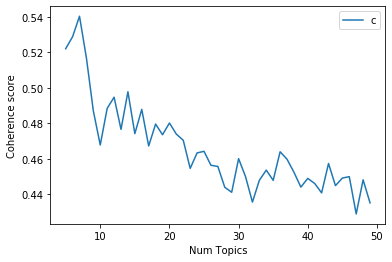

In [5]:
#search optimal topic number
start=5
limit=50
step=1
model_list, coherence_values = compute_coherence_values(dictionary, corpus=corpus, 
                                                        texts=mylist, start=start, limit=limit, step=step)

x = range(start, limit, step)
plt.plot(x, coherence_values)
plt.xlabel("Num Topics")
plt.ylabel("Coherence score")
plt.legend(("coherence_values"), loc='best')
plt.show()

In [6]:
# Build LDA model
NUM_TOPICS = 7
lda_model = LdaModel(corpus=corpus,
                    id2word=dictionary,
                    num_topics=NUM_TOPICS, 
                    random_state=500)

#Save Model
lda_model.save('lda.h5')

In [4]:
#Load Mode
loaded_model = LdaModel.load('lda.h5')

#Test new document
new_doc = 'mempersiapkan diri untuk sbmptn'
new_doc = preprocessing(new_doc)
new_doc_bow = dictionary.doc2bow(new_doc)
print(new_doc_bow)
print(loaded_model.get_document_topics(new_doc_bow))

[(217, 1)]
[(0, 0.10016751), (1, 0.10078695), (2, 0.10132228), (3, 0.10023764), (4, 0.5974856)]


In [7]:
# Print the Keyword in the 10 topics
topics = lda_model.print_topics(num_words=10)
for topic in topics:
    print(topic)

(0, '0.016*"ajar" + 0.010*"orang" + 0.009*"sobat" + 0.007*"jurus" + 0.005*"manajemen" + 0.004*"milik" + 0.004*"sekolah" + 0.004*"kuliah" + 0.004*"didik" + 0.004*"kerja"')
(1, '0.010*"sobat" + 0.007*"orang" + 0.005*"kerja" + 0.005*"ajar" + 0.004*"makan" + 0.004*"tugas" + 0.003*"kuliah" + 0.003*"beasiswa" + 0.003*"it_s" + 0.003*"tidur"')
(2, '0.010*"jurus" + 0.007*"teknik" + 0.007*"statistika" + 0.007*"orang" + 0.006*"ilmu" + 0.005*"kerja" + 0.005*"sobat" + 0.005*"milik" + 0.005*"sistem_informasi" + 0.004*"mahasiswa"')
(3, '0.009*"kuliah" + 0.008*"kerja" + 0.007*"kip" + 0.007*"jurus" + 0.007*"orang" + 0.007*"mahasiswa" + 0.006*"program" + 0.005*"milik" + 0.005*"sobat" + 0.005*"bantu_dana"')
(4, '0.017*"jurus" + 0.009*"ajar" + 0.007*"sobat" + 0.006*"matematika" + 0.005*"ilmu" + 0.005*"kuliah" + 0.005*"milik" + 0.004*"orang" + 0.004*"universitas" + 0.004*"mahasiswa"')
(5, '0.011*"orang" + 0.009*"jurus" + 0.008*"teknik" + 0.008*"sobat" + 0.008*"kuliah" + 0.007*"didik" + 0.007*"ajar" + 0.005